# Analýza: Jak rozvoj solárních a větrných elektráren ovlivňuje ceny elektřiny?

Tento notebook slouží k přípravě datových podkladů a hrubých vizualizací pro [článek na webu Fakta o klimatu](https://faktaoklimatu.cz/explainery/ceny-elektriny-oze).

Data vychází z několika zdrojů. Hlavním zdrojem pro většinu vizualizací jsou [cenové statistiky Eurostatu](https://ec.europa.eu/eurostat/databrowser/product/view/nrg_pc_204_c). Mezi další zdroje patří web [Energy-Charts.info](https://energy-charts.info/) (pro spotové ceny) a web německých provozovatelů přenosových soustav [Netztransparenz](https://www.netztransparenz.de/).


In [15]:
library(nanoparquet)
library(tidyverse)

theme_set(
  theme_minimal(
    base_family = "Roboto",
    base_size = 12
  ) +
    theme(
      axis.text.x = element_text(margin = margin(1.5, 0, 0, 0, "mm")),
      axis.title.x = element_text(
        hjust = 1,
        size = 11
      ),
      axis.title.y = element_text(
        hjust = 1,
        size = 11
      ),
      axis.ticks.x = element_line(colour = "#cccccc"),
      axis.ticks.length.x = unit(1.5, "mm"),
      plot.caption = element_text(colour = "grey60"),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank(),
      panel.grid.minor.y = element_blank(),
      panel.spacing = unit(5, "mm"),
      # Inner plot margins: top, right, bottom left.
      plot.margin = unit(c(0, 0, 0, 0), "mm"),
      plot.title = element_text(face = "bold"),
      strip.clip = "off"
    )
)

options(repr.plot.res = 200)

line_colours <- list(
  commerc = "#7272bf",
  nrg_sup = "#f4465b",
  spot = "#75808e"
)

scale_colour_price_type <- function() {
  scale_colour_manual(
    "",
    values = c(
      NRG_SUP = line_colours$nrg_sup,
      NRG_SUP_h = line_colours$nrg_sup,
      NRG_SUP_nh = line_colours$commerc,
      SpotPrice = line_colours$spot
    ),
    labels = c(
      NRG_SUP = "Energie a dodávky",
      NRG_SUP_h = "En. a dod. (domácnosti)",
      NRG_SUP_nh = "En. a dod. (nedomácnosti)",
      SpotPrice = "Velkoobchodní cena"
    )
  )
}

scale_fill_price_component <- function() {
  scale_fill_manual(
    "Složka ceny",
    labels = c(
      VAT = "DPH",
      TAX = "Další daně\na poplatky",
      NETC = "Náklady na sítě",
      NRG_SUP = "Energie a dodávky"
    ),
    values = c(
      VAT = "#b55f3f",
      TAX = "#f5906c",
      NETC = "#80c9ca",
      NRG_SUP = "#4b8f9e"
    )
  )
}

label_decimals <- \(...) {
  scales::label_number(
    accuracy = .01,
    decimal.mark = ",",
    style_negative = "minus",
    ...
  )
}

translate_country_code <- \(country_code) {
  countrycode::countrycode(
    country_code,
    origin = "iso3c",
    destination = "cldr.name.cs",
    nomatch = NULL
  )
}

export_svg <- \(chart_id) {
  width <- getOption("repr.plot.width")
  height <- getOption("repr.plot.height")
  ggsave(
    file.path(
      "..",
      "outputs",
      "ceny-elektriny-oze",
      paste0(chart_id, ".svg")
    ),
    width = width,
    height = height
  )
}

path_germany_eeg_payments <- "../data/netztransparenz/EEG-2010-2024.csv"
path_household_prices <- "../data/precooked/2024-electricity-prices-household.parquet"
path_nonhousehold_prices <- "../data/precooked/2024-electricity-prices-nonhousehold.parquet"
year_selected <- 2024


In [3]:
household_prices <- read_parquet(path_household_prices) |>
  mutate(
    TAX = TAX_CAP + TAX_OTHER + TAX_RNW,
    TOT = NRG_SUP + NETC + TAX + VAT,
    TOTX_TAX = NRG_SUP + NETC
  ) |>
  filter(Country != "NOR")

nonhousehold_prices <- read_parquet(path_nonhousehold_prices) |>
  mutate(
    TAX = TAX_CAP + TAX_OTHER + TAX_RNW,
    TOT = NRG_SUP + NETC + TAX + VAT,
    TOTX_TAX = NRG_SUP + NETC
  ) |>
  filter(Country != "NOR")


## Graf 01: Průměrné ceny elektřiny pro domácnosti v Česku


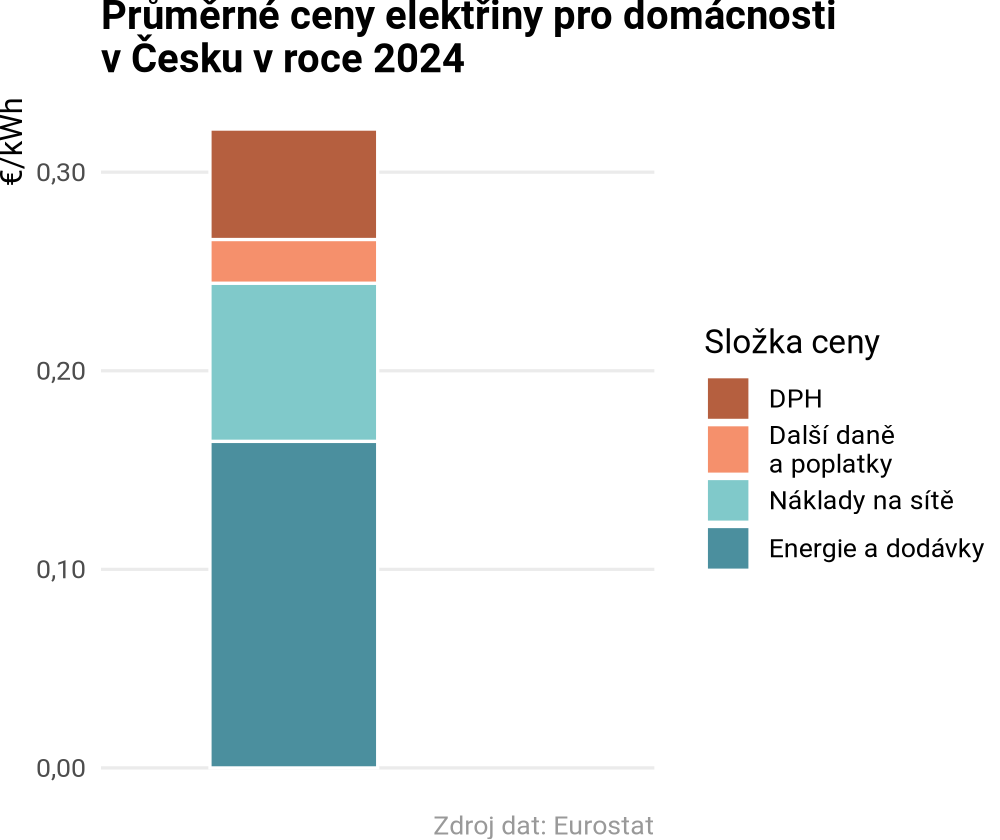

In [4]:
options(repr.plot.width = 5, repr.plot.height = 4.2)

household_prices |>
  filter(
    Country == "CZE",
    Year == year_selected
  ) |>
  select(NETC, NRG_SUP, TAX, VAT) |>
  pivot_longer(everything(), names_to = "Component", values_to = "Price") |>
  mutate(across(Component, ~ fct_relevel(.x, "VAT", "TAX"))) |>
  ggplot(aes(1, Price)) +
  geom_col(
    aes(fill = Component),
    colour = "white",
    width = .5
  ) +
  scale_y_continuous(
    "€/kWh",
    labels = label_decimals()
  ) +
  scale_fill_price_component() +
  xlim(.5, 2) +
  labs(
    title = str_glue("Průměrné ceny elektřiny pro domácnosti\nv Česku v roce {year_selected}"),
    caption = "Zdroj dat: Eurostat"
  ) +
  theme(
    axis.text.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.title.x = element_blank()
  )

export_svg("01-slozky-ceny-cz")


## Graf 02: Vztah mezi cenou zemního plynu a cenou za energii


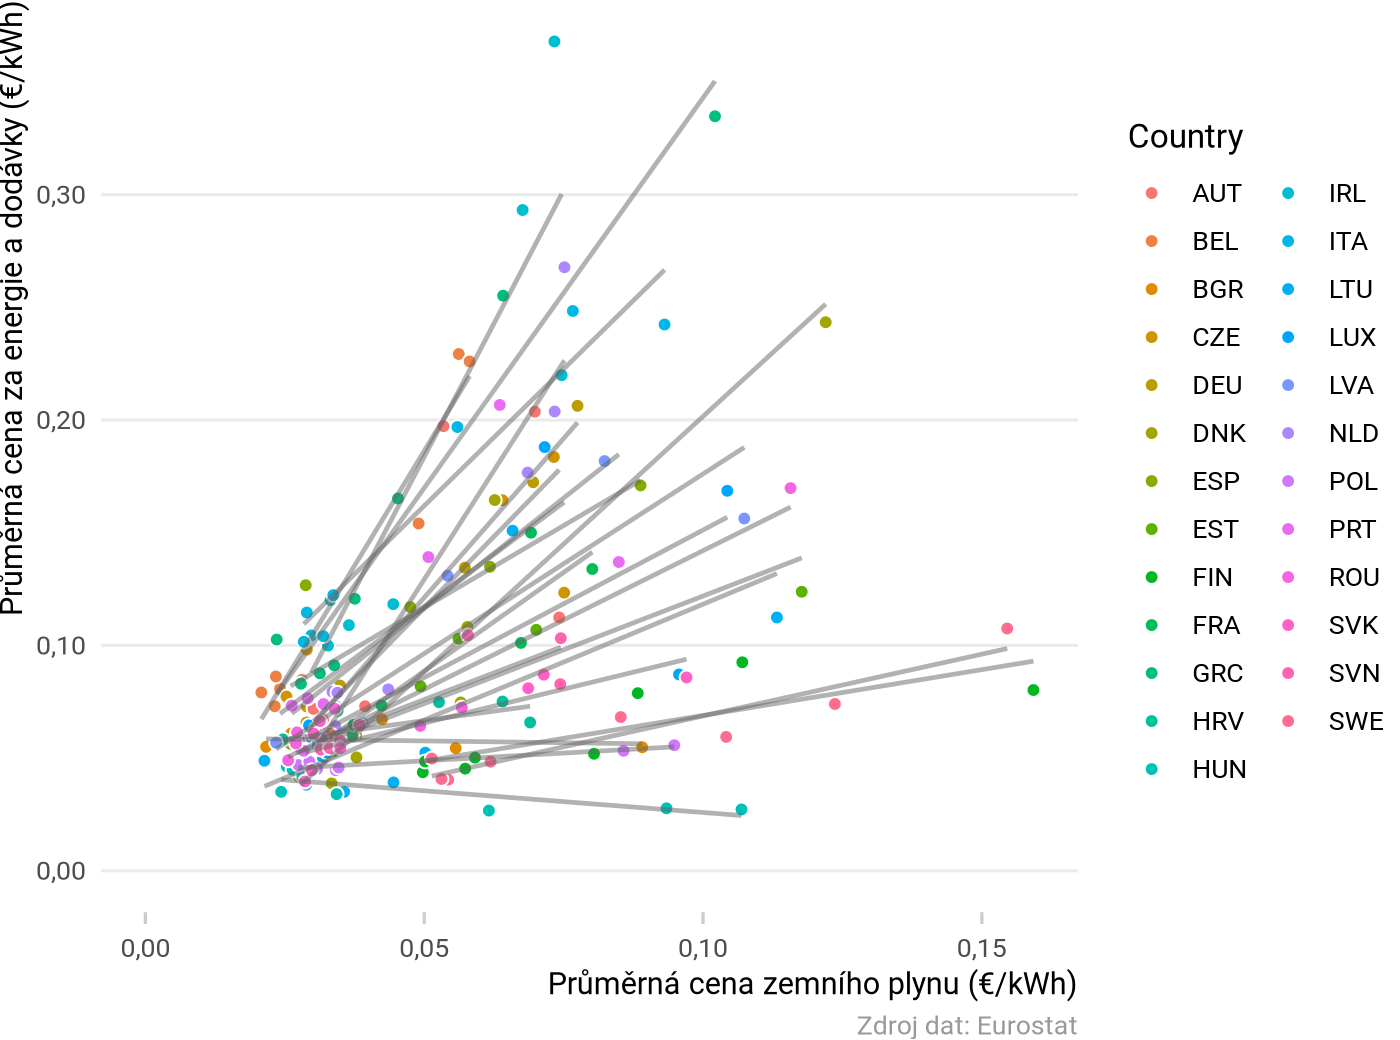

In [5]:
options(repr.plot.width = 7, repr.plot.height = 5.2)

hh_gas_complete_cases <- household_prices |>
  filter(Country != "EU") |>
  select(Country, Year, NRG_SUP, GasPrice) |>
  na.omit()

hh_gas_regression_lines <- hh_gas_complete_cases |>
  group_by(Country) |>
  summarise(
    Lm = list(lm(NRG_SUP ~ GasPrice)),
    xrange = list(range(GasPrice))
  ) |>
  rowwise() |>
  mutate(
    x0 = xrange[1],
    x1 = xrange[2],
    y0 = coef(Lm)[1] + xrange[1] * coef(Lm)[2],
    y1 = coef(Lm)[1] + xrange[2] * coef(Lm)[2]
  )

hh_gas_complete_cases |>
  ggplot(aes(GasPrice, NRG_SUP)) +
  geom_point(
    aes(fill = Country),
    shape = 21,
    colour = "white",
    # fill = "grey40",
    size = 2,
    stroke = .5
  ) +
  geom_segment(
    aes(x = x0, xend = x1, y = y0, yend = y1),
    colour = "grey40",
    data = hh_gas_regression_lines,
    linewidth = .8,
    alpha = .5
  ) +
  scale_x_continuous(
    "Průměrná cena zemního plynu (€/kWh)",
    labels = label_decimals()
  ) +
  scale_y_continuous(
    "Průměrná cena za energie a dodávky (€/kWh)",
    labels = label_decimals()
  ) +
  # scale_colour_manual(
  #   values = c(`FALSE` = "darkcyan", `TRUE` = "lightcoral"),
  #   guide = "none"
  # ) +
  expand_limits(x = 0, y = 0) +
  labs(
    caption = "Zdroj dat: Eurostat"
  )

export_svg("02-scatter-plyn-vs-energie")


## Graf 03: Vztah mezi výstavbou OZE a náklady na sítě


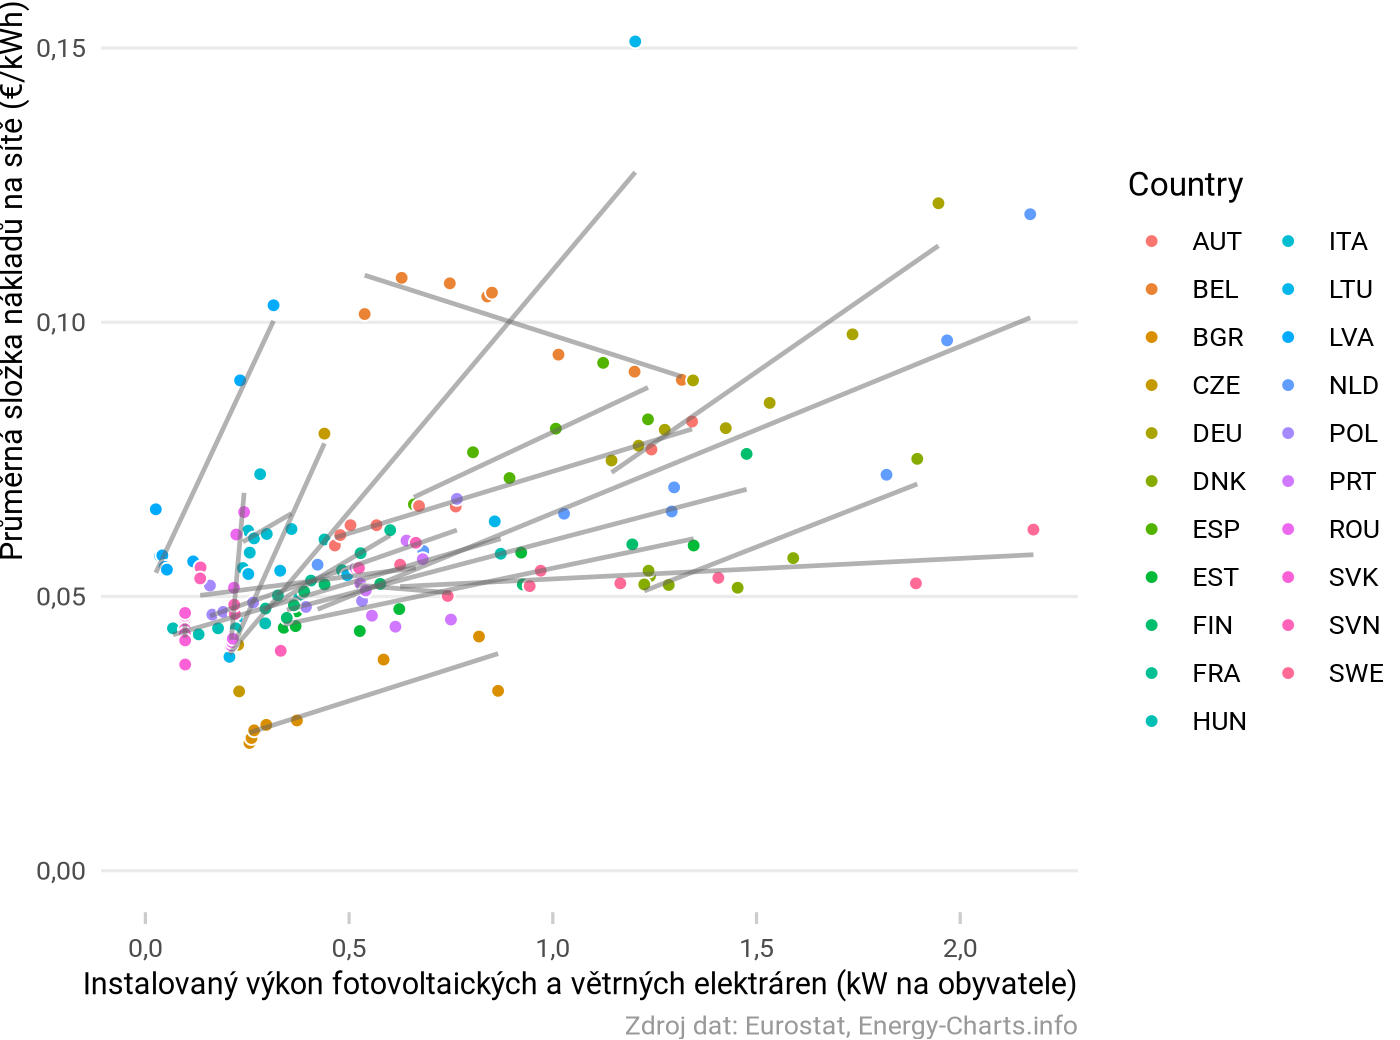

In [6]:
options(repr.plot.width = 7, repr.plot.height = 5.2)

hh_gw_complete_cases <- household_prices |>
  mutate(
    ResInstalled = (SolarGW + WindGW) / Population
  ) |>
  select(Country, Year, ResInstalled, NETC) |>
  na.omit()

hh_gw_regression_lines <- hh_gw_complete_cases |>
  group_by(Country) |>
  summarise(
    Lm = list(lm(NETC ~ ResInstalled)),
    xrange = list(range(ResInstalled))
  ) |>
  rowwise() |>
  mutate(
    x0 = xrange[1],
    x1 = xrange[2],
    y0 = coef(Lm)[1] + xrange[1] * coef(Lm)[2],
    y1 = coef(Lm)[1] + xrange[2] * coef(Lm)[2]
  )

hh_gw_complete_cases |>
  ggplot(aes(ResInstalled, NETC)) +
  geom_point(
    aes(fill = Country),
    shape = 21,
    colour = "white",
    # fill = "grey40",
    size = 2,
    stroke = .5
  ) +
  geom_segment(
    aes(x = x0, xend = x1, y = y0, yend = y1),
    colour = "grey40",
    data = hh_gw_regression_lines,
    linewidth = .8,
    alpha = .5
  ) +
  scale_x_continuous(
    "Instalovaný výkon fotovoltaických a větrných elektráren (kW na obyvatele)",
    labels = scales::label_number(scale = 1e6, decimal.mark = ",")
  ) +
  scale_y_continuous(
    "Průměrná složka nákladů na sítě (€/kWh)",
    labels = label_decimals()
  ) +
  # scale_colour_manual(
  #   values = c(`FALSE` = "darkcyan", `TRUE` = "lightcoral"),
  #   guide = "none"
  # ) +
  expand_limits(x = 0, y = 0) +
  labs(
    caption = "Zdroj dat: Eurostat, Energy-Charts.info"
  )

export_svg("03-scatter-oze-vs-site")


## Graf 04: Ceny elektřiny pro domácnosti v EU


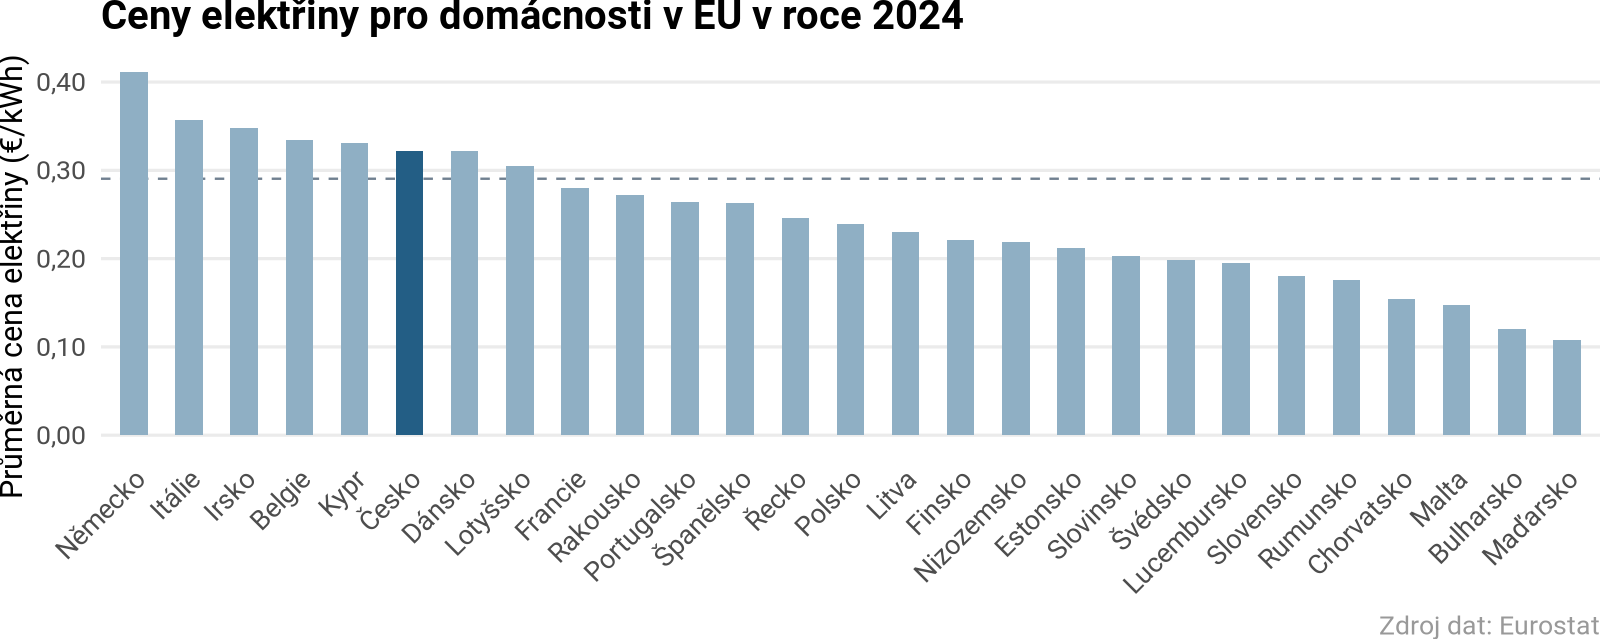

In [7]:
options(repr.plot.width = 8, repr.plot.height = 3.2)

household_prices |>
  filter(Year == year_selected) |>
  mutate(
    Price = TOT,
    across(Country, translate_country_code)
  ) |>
  mutate(across(Country, ~ fct_reorder(.x, Price, .desc = TRUE))) |>
  ggplot(aes(Country, Price)) +
  geom_hline(
    aes(yintercept = Price),
    data = ~ filter(.x, Country == "EU"),
    linewidth = .4,
    linetype = "dashed",
    colour = "slategrey"
  ) +
  geom_col(
    aes(fill = if_else(Country == "Česko", "#235e85", "#8fafc4")),
    data = ~ filter(.x, Country != "EU"),
    width = .5
  ) +
  scale_y_continuous(
    "Průměrná cena elektřiny (€/kWh)",
    labels = label_decimals()
  ) +
  scale_fill_identity(guide = "none") +
  labs(
    title = str_glue("Ceny elektřiny pro domácnosti v EU v roce {year_selected}"),
    caption = "Zdroj dat: Eurostat"
  ) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, margin = margin()),
    axis.ticks.x = element_blank(),
    axis.title.x = element_blank()
  )

export_svg("04-ceny-eu")



## Graf 05: Komponenty cen pro domácnosti v EU


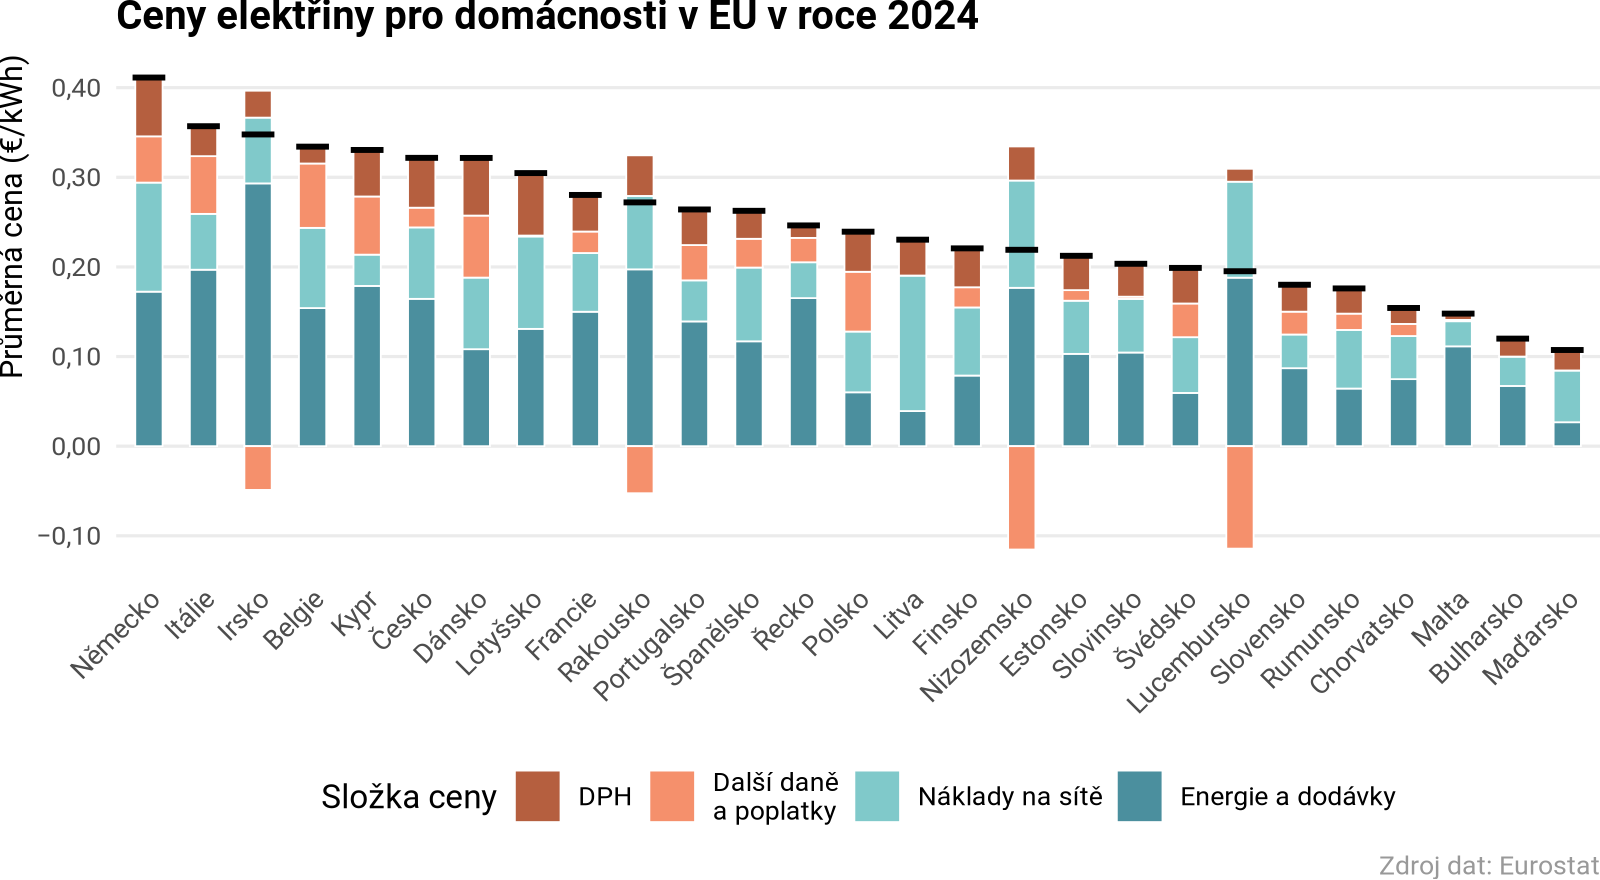

In [24]:
options(repr.plot.width = 8, repr.plot.height = 4.4)

household_prices |>
  filter(
    Country != "EU",
    Year == year_selected
  ) |>
  select(Country, Year, NRG_SUP, NETC, TAX, VAT) |>
  pivot_longer(!Country:Year, names_to = "Component", values_to = "Price") |>
  mutate(
    across(
      Country,
      ~ translate_country_code(.x) |>
        fct_reorder(Price, sum, .desc = TRUE)
    ),
    across(Component, ~ fct_relevel(.x, "VAT", "TAX"))
  ) |>
  ggplot(aes(Country, Price)) +
  geom_col(
    aes(fill = Component),
    colour = "white",
    linewidth = .3,
    width = .5
  ) +
  stat_summary(
    geom = "crossbar",
    fun = sum,
    linewidth = .4,
    width = .6
  ) +
  scale_y_continuous(
    "Průměrná cena (€/kWh)",
    labels = label_decimals()
  ) +
  scale_fill_price_component() +
  labs(
    title = str_glue("Ceny elektřiny pro domácnosti v EU v roce {year_selected}"),
    caption = "Zdroj dat: Eurostat"
  ) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, margin = margin()),
    axis.ticks.x = element_blank(),
    axis.title.x = element_blank(),
    legend.position = "bottom"
  )

export_svg("05-ceny-eu-komponenty")


## Graf 06: Dynamické tarify → Spot vs. energie a dodávky I


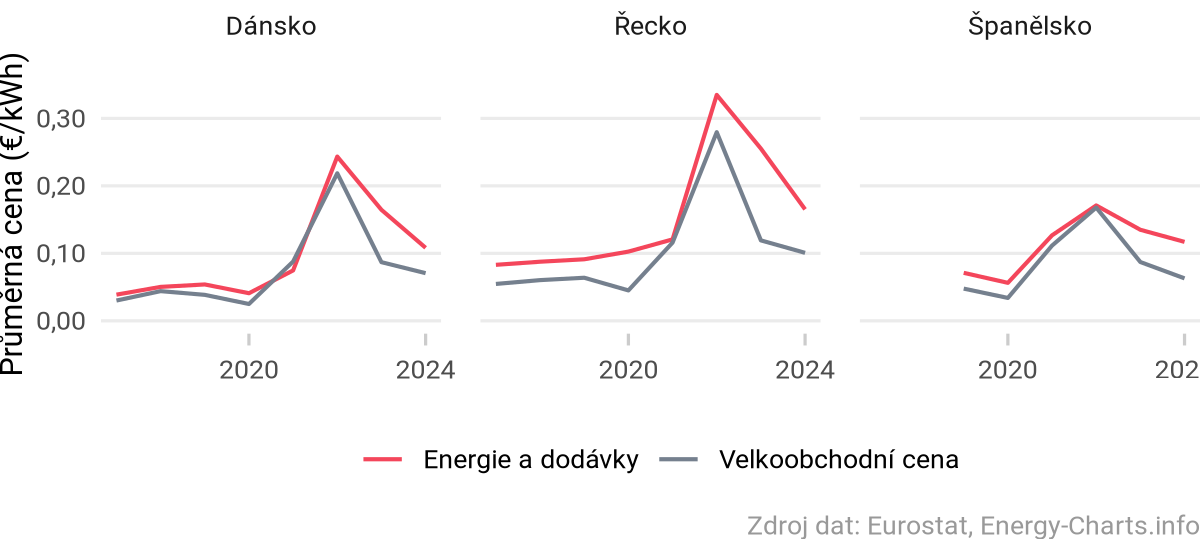

In [18]:
options(repr.plot.width = 6, repr.plot.height = 2.7)

household_prices |>
  filter(Country %in% c("DNK", "ESP", "GRC")) |>
  mutate(across(Country, translate_country_code)) |>
  select(Country, Year, SpotPrice, NRG_SUP) |>
  pivot_longer(
    !Country:Year,
    names_to = "Series",
    values_to = "Value"
  ) |>
  ggplot(aes(Year, Value)) +
  geom_line(aes(colour = Series), linewidth = .7) +
  scale_x_continuous(breaks = c(2020, 2024)) +
  scale_y_continuous(
    "Průměrná cena (€/kWh)",
    labels = label_decimals(),
    limits = c(0, .38)
  ) +
  scale_colour_price_type() +
  facet_grid(cols = vars(Country)) +
  labs(
    caption = "Zdroj dat: Eurostat, Energy-Charts.info"
  ) +
  theme(
    axis.title.x = element_blank(),
    legend.position = "bottom"
  )

export_svg("06-spot-vs-energie-dynamicke")


## Graf 07: Dynamické tarify → Spot vs. energie a dodávky II


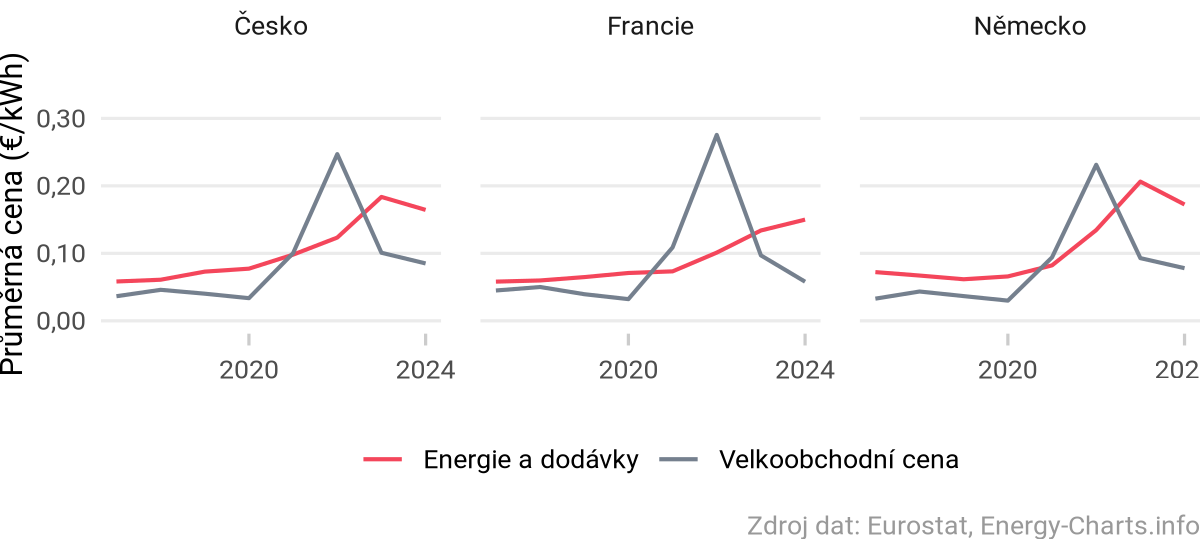

In [17]:
options(repr.plot.width = 6, repr.plot.height = 2.7)

household_prices |>
  filter(Country %in% c("CZE", "DEU", "FRA")) |>
  mutate(across(Country, translate_country_code)) |>
  select(Country, Year, SpotPrice, NRG_SUP) |>
  pivot_longer(
    !Country:Year,
    names_to = "Series",
    values_to = "Value"
  ) |>
  ggplot(aes(Year, Value)) +
  geom_line(aes(colour = Series), linewidth = .7) +
  scale_x_continuous(breaks = c(2020, 2024)) +
  scale_y_continuous(
    "Průměrná cena (€/kWh)",
    labels = label_decimals(),
    limits = c(0, .38)
  ) +
  scale_colour_price_type() +
  facet_grid(cols = vars(Country)) +
  labs(
    caption = "Zdroj dat: Eurostat, Energy-Charts.info"
  ) +
  theme(
    axis.title.x = element_blank(),
    legend.position = "bottom"
  )

export_svg("07-spot-vs-energie-fixovane")


## Graf 08: Zastropování cen


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_line()`).”


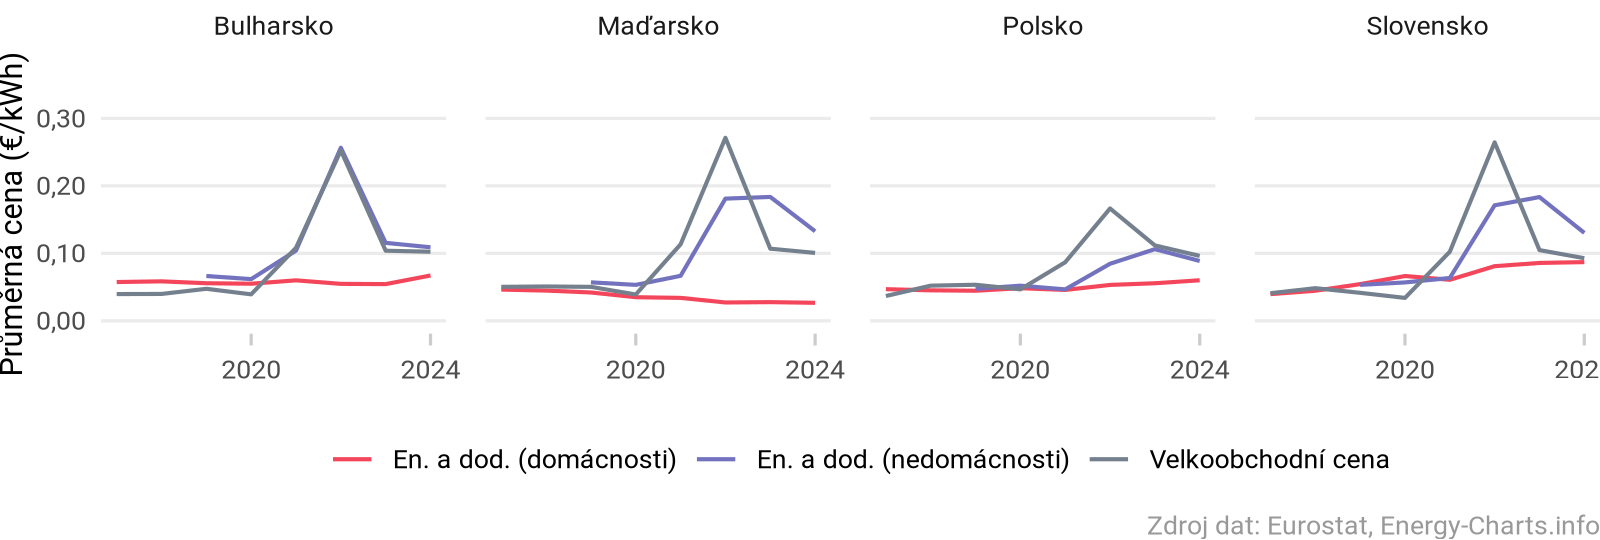

In [16]:
options(repr.plot.width = 8, repr.plot.height = 2.7)

household_prices |>
  filter(Country %in% c("BGR", "HUN", "POL", "SVK")) |>
  select(Country, Year, SpotPrice, NRG_SUP_h = NRG_SUP) |>
  left_join(
    nonhousehold_prices |>
      select(Country, Year, NRG_SUP_nh = NRG_SUP),
    join_by(Country, Year)
  ) |>
  mutate(across(Country, translate_country_code)) |>
  pivot_longer(
    !Country:Year,
    names_to = "Series",
    values_to = "Value"
  ) |>
  ggplot(aes(Year, Value)) +
  geom_line(aes(colour = Series), linewidth = .7) +
  scale_x_continuous(breaks = c(2020, 2024)) +
  scale_y_continuous(
    "Průměrná cena (€/kWh)",
    labels = label_decimals(),
    limits = c(0, .38)
  ) +
  scale_colour_price_type() +
  facet_grid(cols = vars(Country)) +
  labs(
    caption = "Zdroj dat: Eurostat, Energy-Charts.info"
  ) +
  theme(
    axis.title.x = element_blank(),
    legend.position = "bottom"
  )

export_svg("08-spot-vs-energie-zastropovane")


## Graf 09: Slevy na dani a vyúčtování


Dataset query already saved in cache_list.json...

Reading cache file /home/mgrabovsky/.cache/eurostat/a3d5b8c09146199e54aea4ae7b546cbc.rds

Table  nrg_pc_204_c  read from cache file:  /home/mgrabovsky/.cache/eurostat/a3d5b8c09146199e54aea4ae7b546cbc.rds



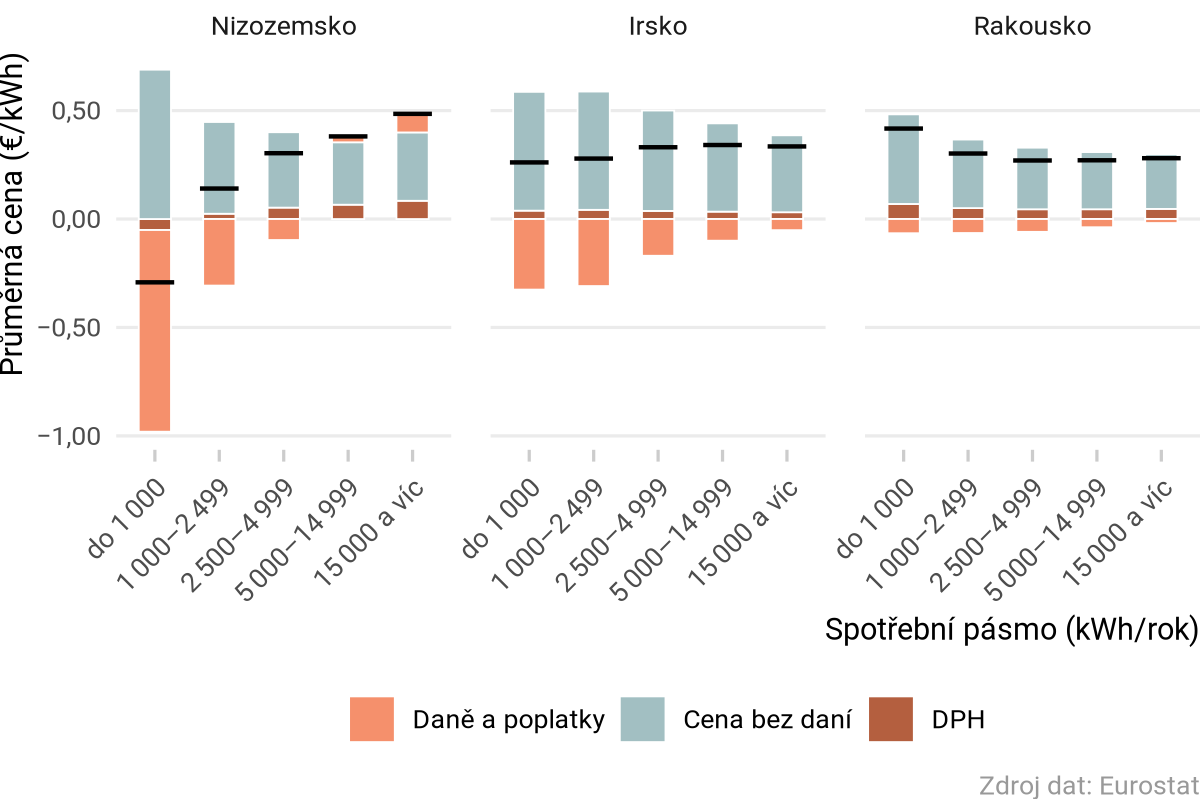

In [30]:
options(repr.plot.width = 6, repr.plot.height = 4)

household_prices_bands <- eurostat::get_eurostat(
  "nrg_pc_204_c",
  select_time = "A",
  filters = list(currency = "EUR")
) |>
  mutate(
    Band = nrg_cons,
    Component = nrg_prc,
    Country = countrycode::countrycode(
      geo,
      origin = "eurostat",
      destination = "iso3c",
      custom_match = c("EA" = "EA", "EU27_2020" = "EU", "XK" = "XK")
    ),
    Year = year(time),
    Price = values,
    .keep = "none"
  ) |>
  pivot_wider(
    names_from = Component,
    values_from = Price
  ) |>
  filter(!is.na(NRG_SUP)) |>
  mutate(
    # Bundle all taxes other than capacity, renewables and VAT
    # into the "other" category.
    TAX_OTHER = TAX_FEE_LEV_CHRG - TAX_CAP - TAX_RNW - VAT
  ) |>
  select(Year:Band, NETC, NRG_SUP, TAX_CAP, TAX_RNW, TAX_OTHER, VAT) |>
  mutate(across(where(is.numeric), ~ round(.x, 4)))

household_prices_bands |>
  filter(
    Country %in% c("AUT", "IRL", "NLD"),
    Band != "TOT_KWH",
    Year == 2023
  ) |>
  mutate(
    Band,
    Country,
    TOTX_TAX = NETC + NRG_SUP,
    TAX = TAX_CAP + TAX_RNW + TAX_OTHER,
    VAT,
    .keep = "none"
  ) |>
  pivot_longer(!Country:Band) |>
  mutate(
    Band = fct_relevel(Band, "KWH_LT1000") |>
      fct_relevel("KWH_LE15000", after = 4)
  ) |>
  mutate(
    across(
      Country,
      ~ translate_country_code(.x) |>
        fct_relevel("Nizozemsko", "Irsko", "Rakousko")
    )
  ) |>
  ggplot(aes(Band, value)) +
  geom_col(
    aes(fill = name),
    colour = "white",
    linewidth = .3,
    width = .5
  ) +
  stat_summary(geom = "crossbar", fun = sum, linewidth = .3, width = .6) +
  facet_wrap(vars(Country)) +
  scale_x_discrete(
    "Spotřební pásmo (kWh/rok)",
    labels = c(
      "do 1 000",
      "1 000–2 499",
      "2 500–4 999",
      "5 000–14 999",
      "15 000 a víc"
    )
  ) +
  scale_y_continuous(
    "Průměrná cena (€/kWh)",
    labels = label_decimals()
  ) +
  scale_fill_manual(
    "",
    values = c(TAX = "#f5906c", TOTX_TAX = "#a2bfc2", VAT = "#b45f3f"),
    labels = c(TAX = "Daně a poplatky", TOTX_TAX = "Cena bez daní", VAT = "DPH")
  ) +
  labs(caption = "Zdroj dat: Eurostat") +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    legend.position = "bottom"
  )

export_svg("09-ceny-slevy")


## Graf 10: Přesun nákladů do rozpočtu


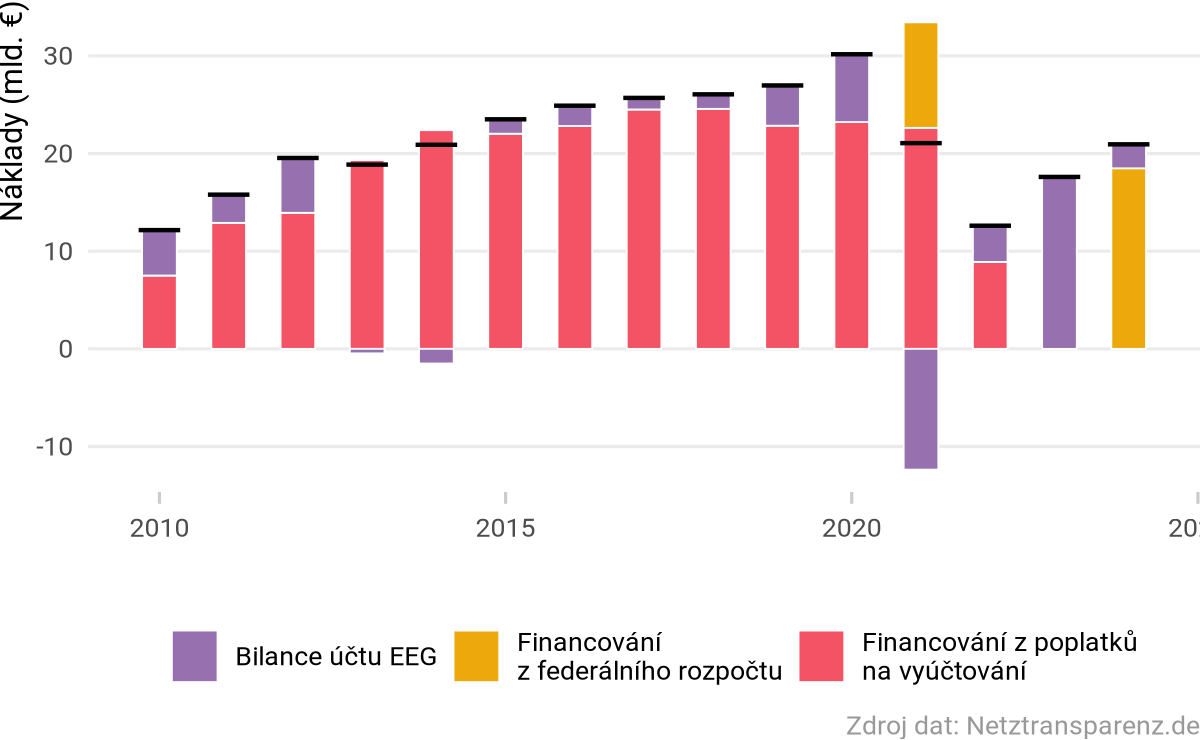

In [31]:
options(repr.plot.width = 6, repr.plot.height = 3.7)

germany_res_payments <- read_csv(path_germany_eeg_payments) |>
  select(!c(source_pdf, notes)) |>
  mutate(across(payments_to_producers_eur:federal_budget_transfers_eur, ~ .x / 1e9))

germany_res_payments |>
  mutate(
    eeg_account = payments_to_producers_eur - income_from_eeg_levy_eur
      - federal_budget_transfers_eur
  ) |>
  select(!payments_to_producers_eur) |>
  pivot_longer(!year) |>
  ggplot(aes(year, value)) +
  geom_col(
    aes(fill = name),
    colour = "white",
    linewidth = .3,
    width = .5
  ) +
  scale_fill_manual(
    "",
    values = c(
      eeg_account = "#9670af",
      federal_budget_transfers_eur = "#eda80c",
      income_from_eeg_levy_eur = "#f45366"
    ),
    labels = c(
      eeg_account = "Bilance účtu EEG",
      federal_budget_transfers_eur = "Financování\nz federálního rozpočtu",
      income_from_eeg_levy_eur = "Financování z poplatků\nna vyúčtování"
    )
  ) +
  stat_summary(geom = "crossbar", fun = sum, linewidth = .3, width = .6) +
  labs(
    x = "",
    y = "Náklady (mld. €)",
    caption = "Zdroj dat: Netztransparenz.de"
  ) +
  theme(legend.position = "bottom")

export_svg("10-naklady-nemecko")
